## ResNets

Resnets were introduced by He et. al. [(2016)](https://arxiv.org/pdf/1512.03385.pdf). They presented the idea that every layer should be able to learn




## The Residual Block
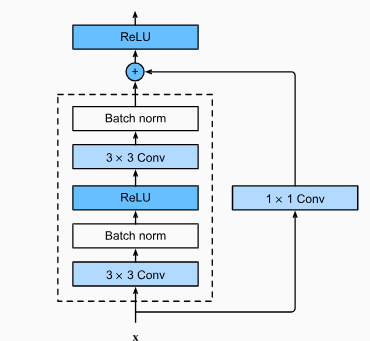

In [ ]:
import torch

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device = ', device)

device =  cuda


In [ ]:
class ConvNet(torch.nn.Module):
  class ConvBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
      super().__init__()
      self.net = torch.nn.Sequential(
          torch.nn.Conv2d(in_channels,
                          out_channels,
                          kernel_size=3,
                          padding=1,
                          stride=stride,
                          bias=False),
          torch.nn.BatchNorm2d(out_channels),
          torch.nn.ReLU(),
          torch.nn.Conv2d(out_channels,
                          out_channels,
                          kernel_size=3,
                          padding=1,
                          stride=1,
                          bias=False),
          torch.nn.BatchNorm2d(out_channels),
          torch.nn.ReLU()
      )

    def forward(self, x):
      return self.net(x)

  def __init__(self, in_channels, n_classes):
    super().__init__()
    L = [
        torch.nn.Conv2d(in_channels, 64, kernel_size=7, padding=3, stride=2, bias=False),
        torch.nn.BatchNorm2d(64),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
    ]
    list_channels = [64,64,64,128,128,128,128,256,256,256,256,512,512,512,512]
    c0 = 64
    for c1 in list_channels:
      st = 1
      if c0 != c1:
        st = 2
      L.append(self.ConvBlock(c0,c1,st))
      c0=c1

    self.network = torch.nn.Sequential(*L)
    self.classifier  = torch.nn.Linear(c0, n_classes)

  def forward(self, x):
    y = self.network(x)
    y = y.mean(dim=[2,3])
    return self.classifier(y)

In [ ]:
class ResNet(torch.nn.Module):
  class ResBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
      super().__init__()
      self.net = torch.nn.Sequential(
          torch.nn.Conv2d(in_channels,
                          out_channels,
                          kernel_size=3,
                          padding=1,
                          stride=stride,
                          bias=False),
          torch.nn.BatchNorm2d(out_channels),
          torch.nn.ReLU(),
          torch.nn.Conv2d(out_channels,
                          out_channels,
                          kernel_size=3,
                          padding=1,
                          stride=1,
                          bias=False),
          torch.nn.BatchNorm2d(out_channels),
          torch.nn.ReLU()
      )

      self.downsample = None
      if stride!=1 or in_channels!=out_channels:
        self.downsample = torch.nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size=1, stride = stride),
                                              torch.nn.BatchNorm2d(out_channels))

    def forward(self, x):
      y = x
      if self.downsample is not None:
        y = self.downsample(x)

      return y + self.net(x)

  def __init__(self, in_channels, n_classes):
    super().__init__()
    L = [
        torch.nn.Conv2d(in_channels, 64, kernel_size=7, padding=3, stride=2, bias=False),
        torch.nn.BatchNorm2d(64),
        torch.nn.ReLU(),
        # torch.nn.Conv2d(64, 64, kernel_size=3, padding=1, stride=1, bias=False),
        torch.nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
    ]
    list_channels = [64,64,64,128,128,128,128,256,256,256,256,512,512,512,512]#[64,128,256,512]#
    c0 = 64
    for c1 in list_channels:
      st = 1
      if c0 != c1:
        st = 2
      L.append(self.ResBlock(c0,c1,st))
      c0=c1

    self.network = torch.nn.Sequential(*L)
    self.classifier  = torch.nn.Linear(c0, n_classes)

  def forward(self, x):
    y = self.network(x)
    y = y.mean(dim=[2,3])
    return self.classifier(y)

In [ ]:
conv_net = ConvNet(3,1000)
conv_net.train()
conv_net.training


True

In [ ]:
res_net = ResNet(3,1000)
res_net.train()
res_net.training

True

In [ ]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.utils.data as data

In [ ]:
batch_size = 8
transform = transforms.Compose([
    transforms.RandomCrop((384,384)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])
trainset = datasets.Flowers102(root='./data', split="train", download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
validset = datasets.Flowers102(root='./data', split="val", download=True, transform=transform)
validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=True, num_workers=2)
for data, labels in trainloader:
  print(data.shape)
  print(labels)
  break

torch.Size([8, 3, 384, 384])
tensor([ 3, 58,  3,  4, 23, 66, 81, 55])


In [ ]:
import wandb
from tqdm import tqdm
import numpy as np

def calculate_accuracy(predictions, targets):
    _, predicted = torch.max(predictions, 1)
    # print(predicted)
    # print(targets)
    correct = (predicted == targets).sum().item()
    total = targets.size(0)
    accuracy = correct / total
    return accuracy

n_epochs = 500
wandb.init(project='convnet_v_resnet', name='experiment_15', config={"epochs": n_epochs, "dataset":"flowers102"})

conv_net = conv_net.to(device)
res_net = res_net.to(device)

optimizer_conv = torch.optim.Adam(conv_net.parameters())
optimizer_resnet = torch.optim.Adam(res_net.parameters())
loss_function = torch.nn.CrossEntropyLoss()

scheduler_conv = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_conv, 'max')
scheduler_resnet = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_resnet, 'max')

global_step = 0

for epoch in tqdm(range(n_epochs)):
    conv_net.train()
    res_net.train()

    conv_accuracies = []
    res_accuracies = []

    for data, labels in trainloader:
        data, labels = data.to(device), labels.long().to(device)

        conv_output = conv_net(data)
        conv_loss = loss_function(conv_output, labels)
        conv_accuracy = calculate_accuracy(conv_output, labels)
        conv_accuracies.append(conv_accuracy)

        resnet_output = res_net(data)
        resnet_loss = loss_function(resnet_output, labels)

        resnet_accuracy = calculate_accuracy(resnet_output, labels)
        res_accuracies.append(resnet_accuracy)

        wandb.log({
            'convnet/loss': conv_loss.item(),
            'resnet/loss': resnet_loss.item()
        }, step=global_step)

        optimizer_conv.zero_grad()
        conv_loss.backward()
        optimizer_conv.step()

        optimizer_resnet.zero_grad()
        resnet_loss.backward()
        optimizer_resnet.step()

        global_step += 1

    conv_accuracies_val = []
    res_accuracies_val = []

    for data,labels in validloader:
        data, labels = data.to(device), labels.long().to(device)

        conv_output = conv_net(data)
        conv_accuracy = calculate_accuracy(conv_output, labels)
        conv_accuracies_val.append(conv_accuracy)

        resnet_output = res_net(data)
        resnet_accuracy = calculate_accuracy(resnet_output, labels)
        res_accuracies_val.append(resnet_accuracy)
    scheduler_conv.step(np.mean(conv_accuracies))
    scheduler_resnet.step(np.mean(res_accuracies))
    wandb.log({
            'convnet/accuracy': np.mean(conv_accuracies),
            'resnet/accuracy': np.mean(res_accuracies),
            'convnet/accuracy_val': np.mean(conv_accuracies_val),
            'resnet/accuracy_val': np.mean(res_accuracies_val)
        }, step=global_step)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: aashutosh-pyakurel (fuse-cv). Use `wandb login --relogin` to force relogin


100%|██████████| 500/500 [3:58:24<00:00, 28.61s/it]  


In [ ]:
torch.save(conv_net.state_dict(), 'weights/conv_500.pth')
torch.save(res_net.state_dict(), 'weights/resnet_500.pth')

In [ ]:
conv_net.eval()
res_net.eval()

ResNet(
  (network): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): ResBlock(
      (net): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
      )
    )
    (5): ResBlock(
      (net): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [ ]:
import json
with open('data/flowers-102/cat_to_name.json', 'r') as file:
    class_idx = json.load(file)

Convnet Ranking: class (score)
0: azalea (-5.9648)
1: colt's foot (-8.4961)
2: lotus lotus (-9.0271)
3: columbine (-9.9888)
4: cape flower (-10.2623)
5: pelargonium (-10.3625)
6: common dandelion (-10.5316)
7: tree mallow (-10.5804)
8: morning glory (-10.9495)
9: trumpet creeper (-11.1194)
Resnet Ranking: class (score)
0: azalea (4.4507)
1: lenten rose (4.1037)
2: colt's foot (0.5538)
3: hippeastrum (-0.0393)
4: water lily (-0.0939)
5: toad lily (-0.6631)
6: buttercup (-1.7791)
7: orange dahlia (-2.3208)
8: passion flower (-2.3987)
9: carnation (-2.6927)


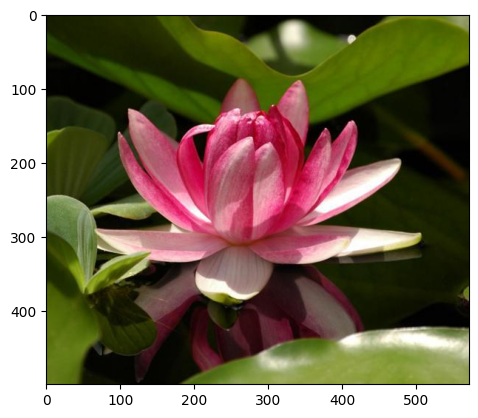

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
image = transform(Image.open('data/flowers-102/jpg/image_00292.jpg'))
plt.imshow(plt.imread('data/flowers-102/jpg/image_00292.jpg'))

conv_preds = conv_net(image.unsqueeze(0).to(device)).detach().cpu().numpy()[0]
res_preds = res_net(image.unsqueeze(0).to(device)).detach().cpu().numpy()[0]

print('Convnet Ranking: class (score)')
for i, idx in enumerate(np.argsort(conv_preds)[-10:][::-1]):
    print('%d: %s (%.04f)' % (
            i,
            class_idx[str(idx)],
            conv_preds[idx]))

print('Resnet Ranking: class (score)')
for i, idx in enumerate(np.argsort(res_preds)[-10:][::-1]):
    print('%d: %s (%.04f)' % (
            i,
            class_idx[str(idx)],
            res_preds[idx]))

In [ ]:
def visualize_layer(weight):
    fig=plt.figure(figsize=(8, 8))

    for i in range(64):
        x = weight[i, ...].transpose([1, 2, 0])
        x = (x - np.min(x))/np.ptp(x)

        fig.add_subplot(8, 8, i + 1)
        if x.shape[2] == 3:
            plt.imshow(x)
        else:
            plt.imshow(x[:,:,0])
        plt.axis('off')

    plt.show()

In [ ]:
!pip install torch-summary

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
from torchsummary import summary
summary(conv_net, (3,384,384))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 12, 12]         --
|    └─Conv2d: 2-1                       [-1, 64, 192, 192]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 192, 192]        128
|    └─ReLU: 2-3                         [-1, 64, 192, 192]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 96, 96]          --
|    └─ConvBlock: 2-5                    [-1, 64, 96, 96]          --
|    |    └─Sequential: 3-1              [-1, 64, 96, 96]          73,984
|    └─ConvBlock: 2-6                    [-1, 64, 96, 96]          --
|    |    └─Sequential: 3-2              [-1, 64, 96, 96]          73,984
|    └─ConvBlock: 2-7                    [-1, 64, 96, 96]          --
|    |    └─Sequential: 3-3              [-1, 64, 96, 96]          73,984
|    └─ConvBlock: 2-8                    [-1, 128, 48, 48]         --
|    |    └─Sequential: 3-4              [-1, 128, 48, 48]         22

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 12, 12]         --
|    └─Conv2d: 2-1                       [-1, 64, 192, 192]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 192, 192]        128
|    └─ReLU: 2-3                         [-1, 64, 192, 192]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 96, 96]          --
|    └─ConvBlock: 2-5                    [-1, 64, 96, 96]          --
|    |    └─Sequential: 3-1              [-1, 64, 96, 96]          73,984
|    └─ConvBlock: 2-6                    [-1, 64, 96, 96]          --
|    |    └─Sequential: 3-2              [-1, 64, 96, 96]          73,984
|    └─ConvBlock: 2-7                    [-1, 64, 96, 96]          --
|    |    └─Sequential: 3-3              [-1, 64, 96, 96]          73,984
|    └─ConvBlock: 2-8                    [-1, 128, 48, 48]         --
|    |    └─Sequential: 3-4              [-1, 128, 48, 48]         22

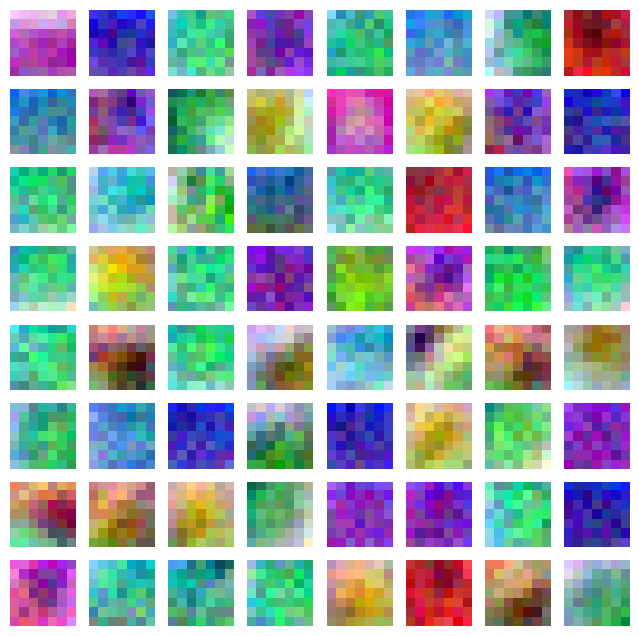

In [ ]:
visualize_layer(conv_net.network[0].weight.data.cpu().numpy())

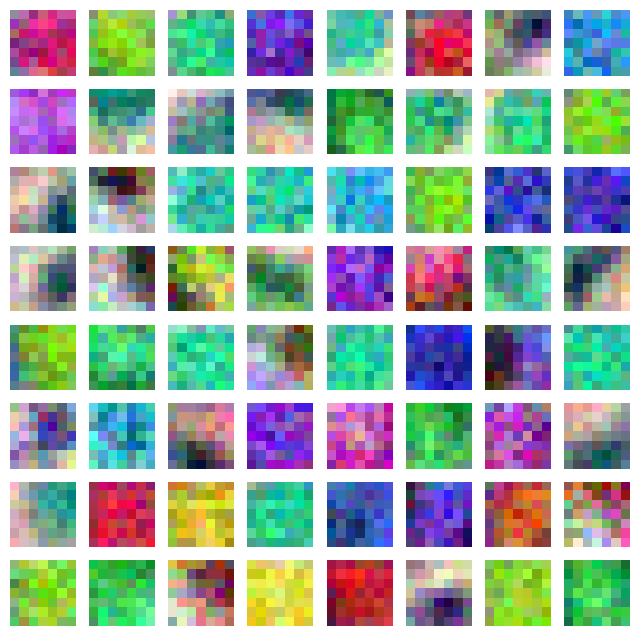

In [ ]:
visualize_layer(res_net.network[0].weight.data.cpu().numpy())

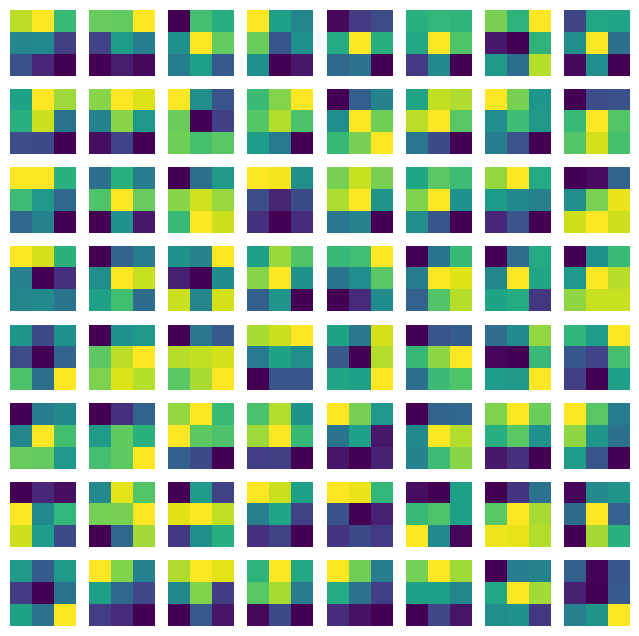

In [ ]:
visualize_layer(conv_net.network[4].net[3].weight.data.cpu().numpy())

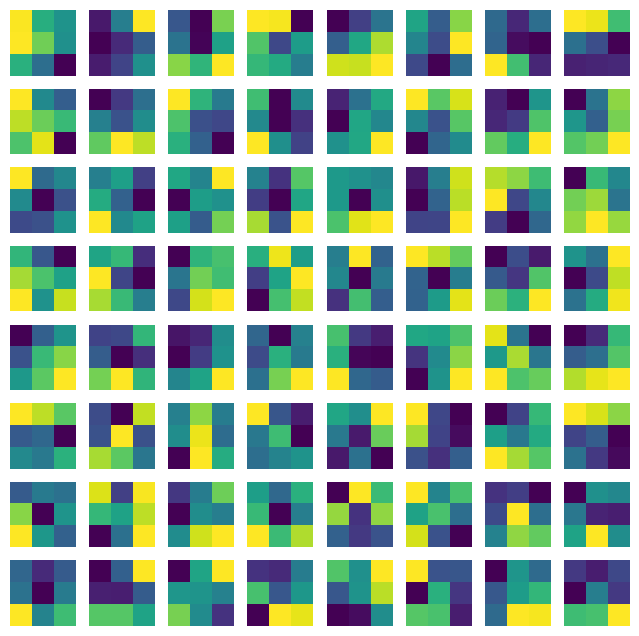

In [ ]:
visualize_layer(res_net.network[4].net[3].weight.data.cpu().numpy())

In [ ]:
def undo_transform(x):
    mean = np.array([0.485, 0.456, 0.406])[np.newaxis, :, np.newaxis, np.newaxis]
    std = np.array([0.229, 0.224, 0.225])[np.newaxis, :, np.newaxis, np.newaxis]
    return (x * std) + mean

In [ ]:
all_data = []
C1 = []
C2 = []
C3 = []

def store_activation(L, m, grad_in, grad_out):
    L.append(grad_out.detach().cpu().numpy())


try:
    h1 = res_net.network[0].register_forward_hook(lambda *args: store_activation(C1, *args))
    h2 = res_net.network[4].net[0].register_forward_hook(lambda *args: store_activation(C2, *args))
    h3 = res_net.network[5].net[0].register_forward_hook(lambda *args: store_activation(C3, *args))

    for it, (data, label) in enumerate(validset):
        all_data.append(undo_transform(data.numpy()))
        if device is not None:
            data, label = data.to(device), label
        result = res_net(data.unsqueeze(0))
finally:
    h1.remove()
    h2.remove()
    h3.remove()

all_data = np.vstack(all_data)
C1 = np.vstack(C1)
C2 = np.vstack(C2)
C3 = np.vstack(C3)

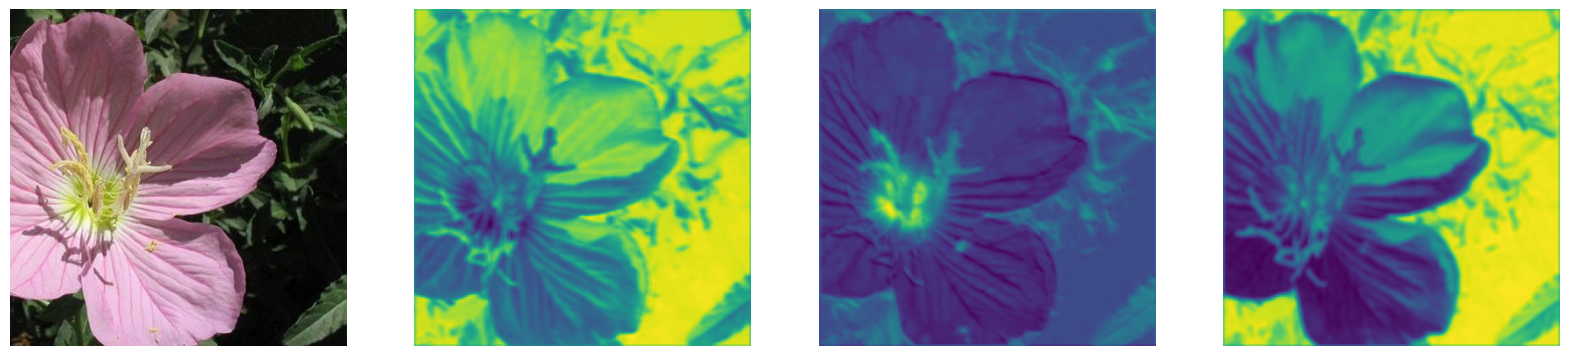

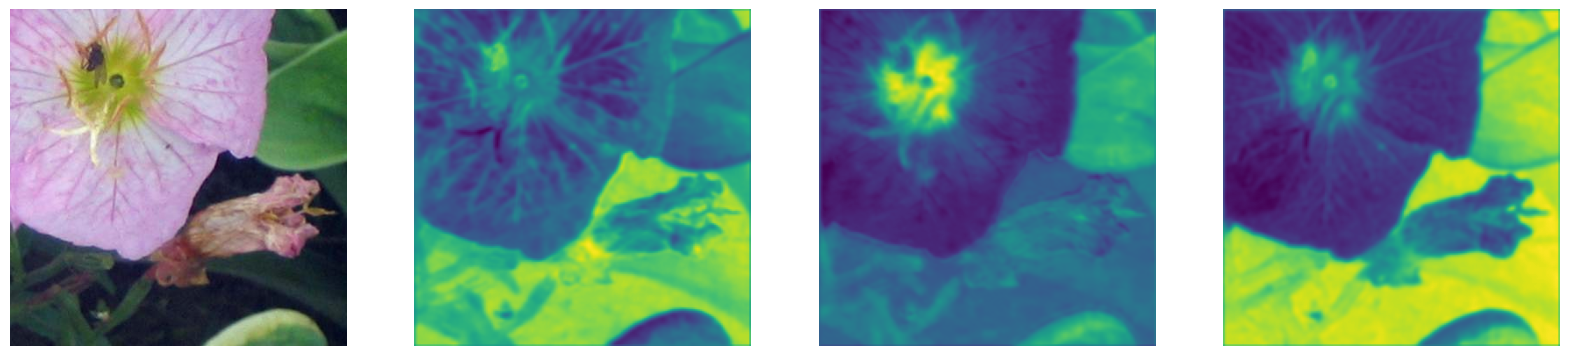

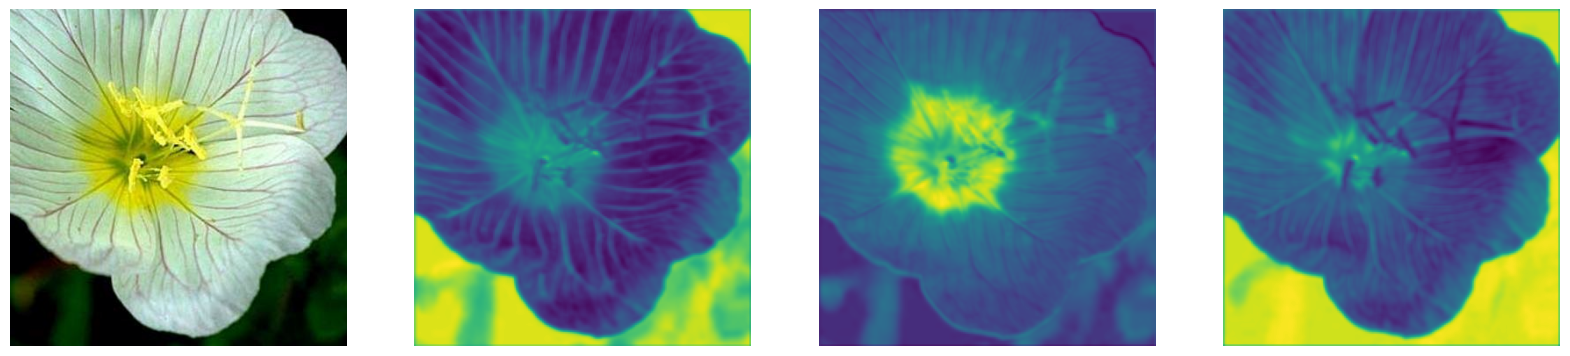

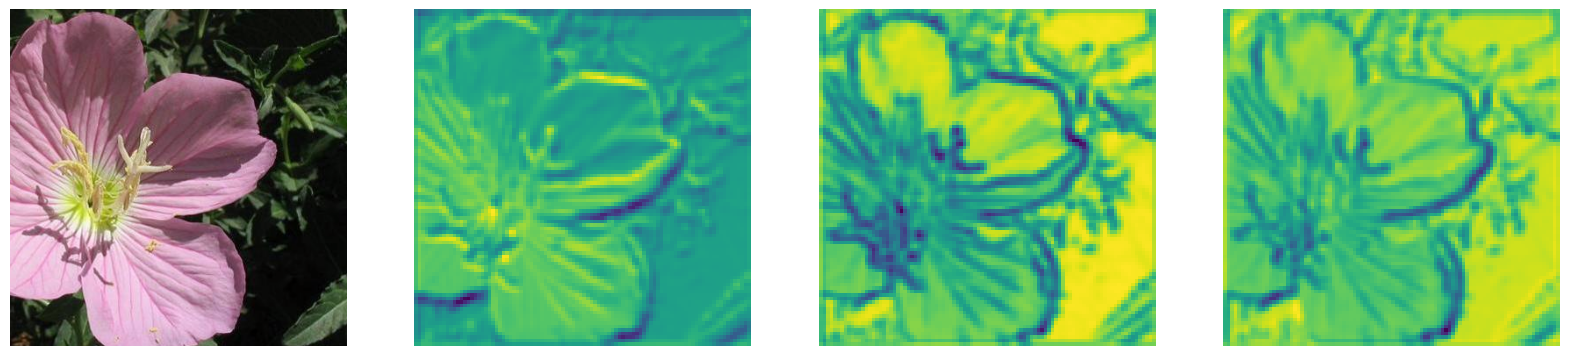

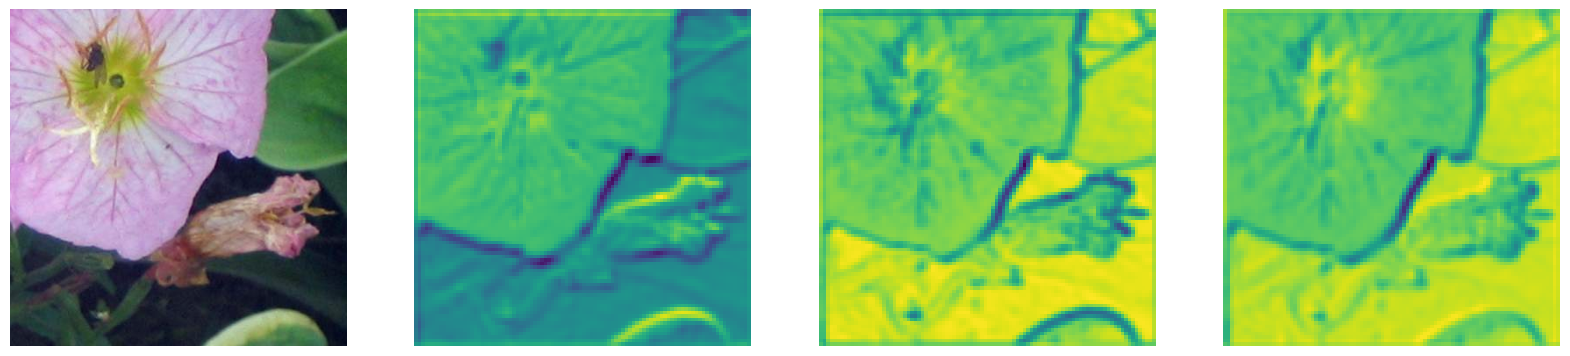

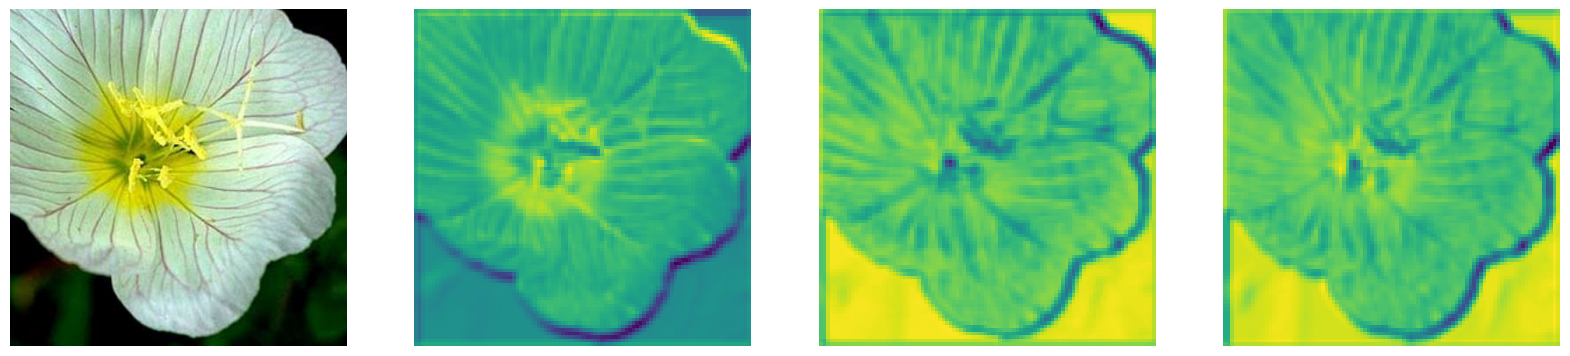

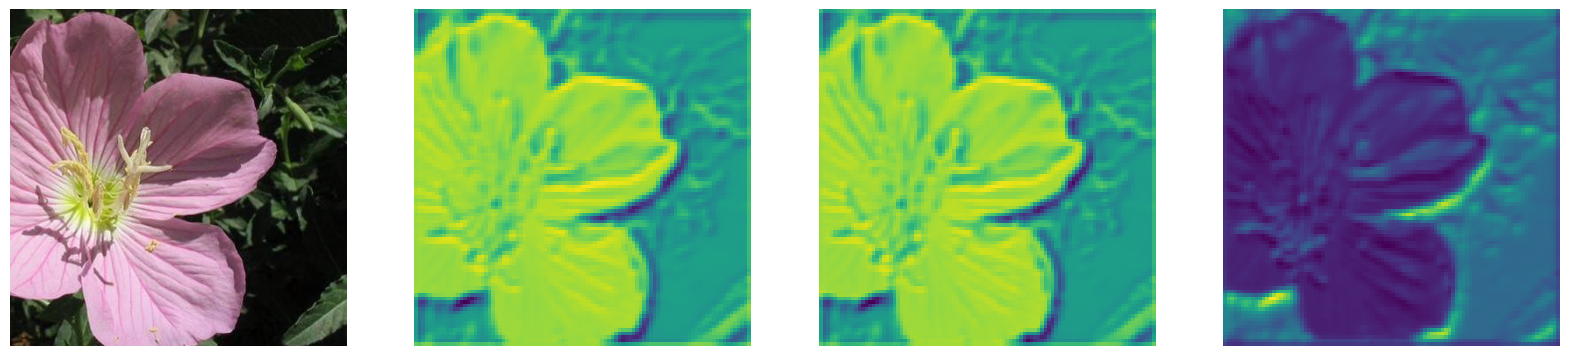

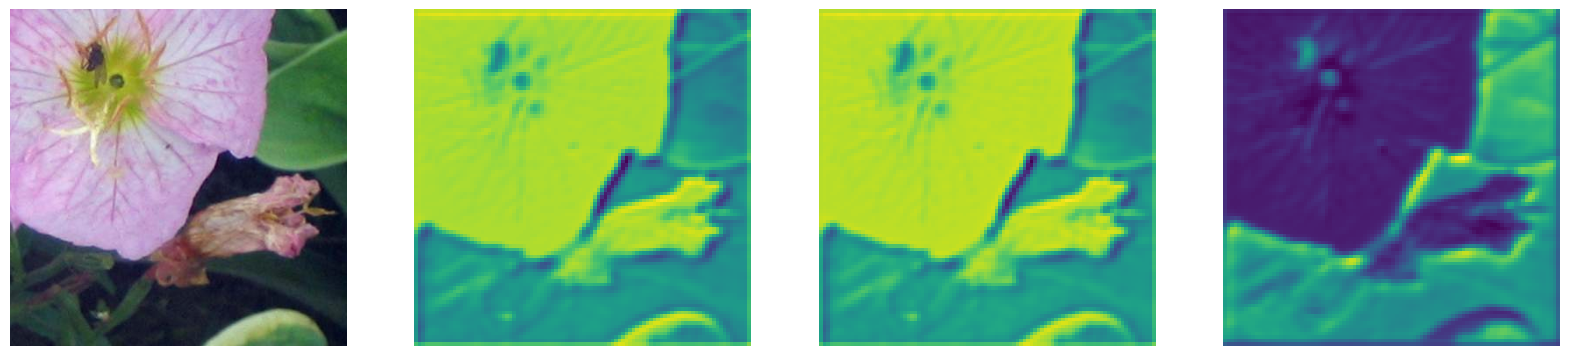

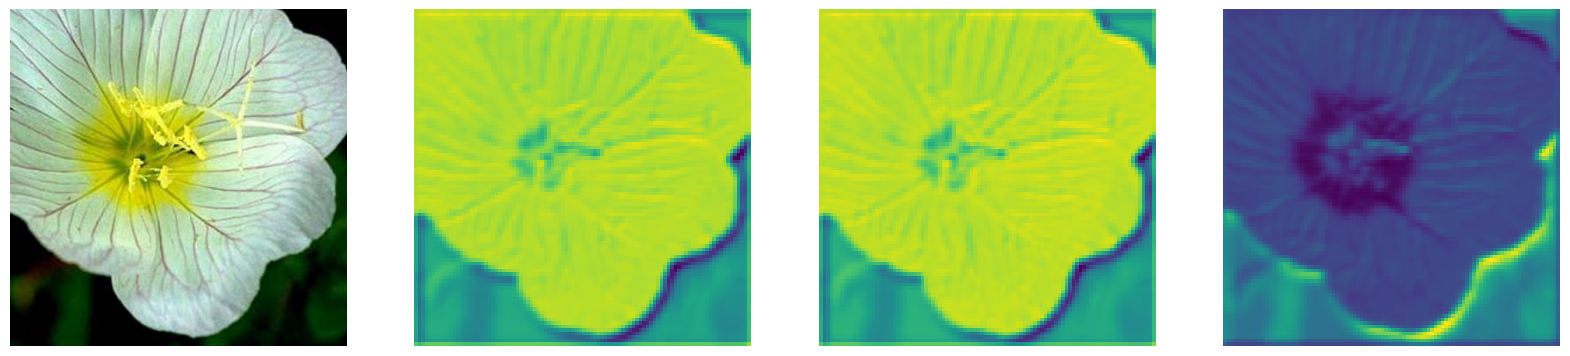

In [ ]:
def to_pil(x):
    x = x.transpose((1, 2, 0))
    x -= x.min(0).min(0)[None,None]
    x /= x.max(0).max(0)[None,None]
    return Image.fromarray((x * 255).astype('uint8'))

def viz_act(img, act):

    num_acts = len(act)
    img = to_pil(img)

    fig=plt.figure(figsize=(20, 20))

    fig.add_subplot(1, 1+num_acts, 1)
    plt.imshow(img)
    plt.axis('off')

    for i, c in enumerate(act):
        fig.add_subplot(1, 1+num_acts, i + 2)
        plt.imshow(c)
        plt.axis('off')

    plt.show()

for i in range(3):
    viz_act(all_data[i], C1[i, :3])


for i in range(3):
    viz_act(all_data[i], C2[i, :3])

for i in range(3):
    viz_act(all_data[i], C3[i, :3])

/tmp/ipykernel_36342/19650623.py:4: RuntimeWarning: invalid value encountered in divide
  x /= x.max(0).max(0)[None,None]
/tmp/ipykernel_36342/19650623.py:5: RuntimeWarning: invalid value encountered in cast
  return Image.fromarray((x * 255).astype('uint8'))


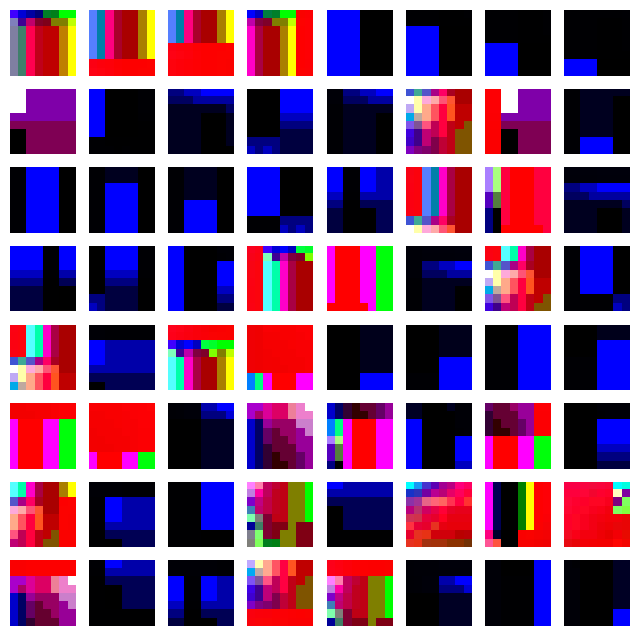

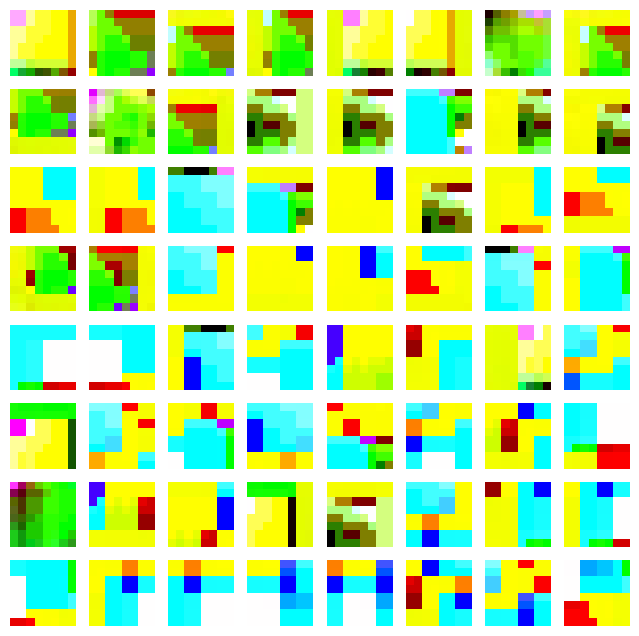

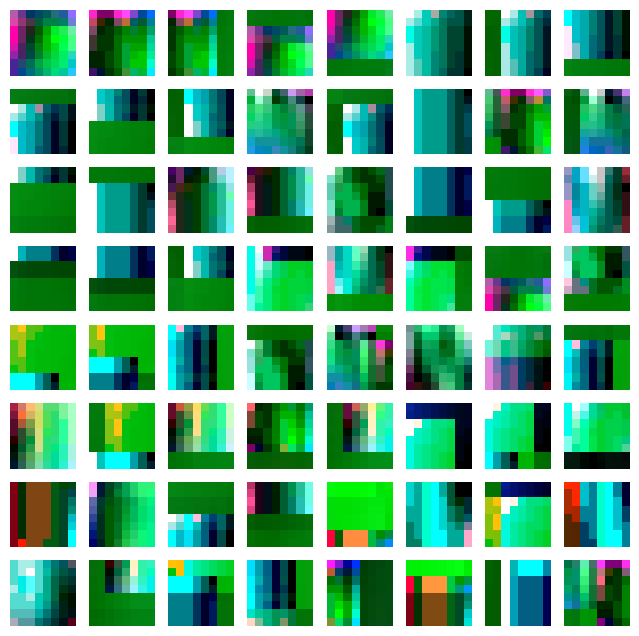

In [ ]:
def find_max_act(C, filter, W=10, img_size=[384,384]):
    fig=plt.figure(figsize=(8, 8))

    filter_act = C[:, filter]
    for i, idx in enumerate(np.argsort(-filter_act, axis=None)[:64]):
        max_pos = list(np.unravel_index(idx, filter_act.shape))

        max_pos[1] = int(max_pos[1] * float(img_size[0]) / filter_act.shape[1])
        max_pos[2] = int(max_pos[2] * float(img_size[1]) / filter_act.shape[2])

        img = to_pil(all_data[max_pos[0],
                              :,
                              max(max_pos[1] - W, 0) : max_pos[1] + W,
                              max(max_pos[2] - W, 0) : max_pos[2] + W])

        fig.add_subplot(8, 8, i + 1)
        plt.imshow(img)
        plt.axis('off')

    plt.show()

find_max_act(C1, filter=0, W=4)#, img_size=img.size)
find_max_act(C1, filter=1, W=4)#, img_size=img.size)
find_max_act(C1, filter=2, W=4)#, img_size=img.size)

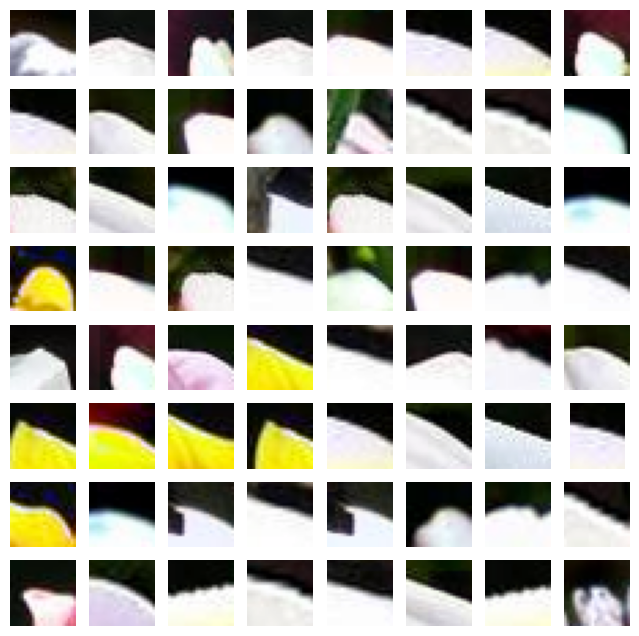

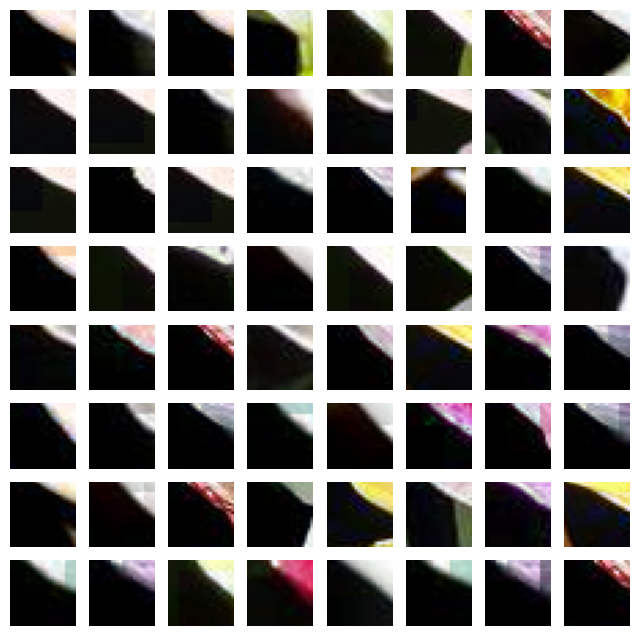

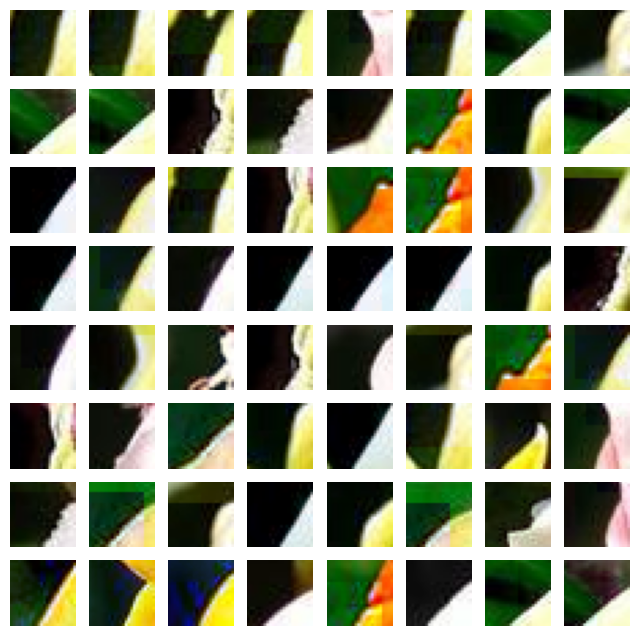

In [ ]:
find_max_act(C2, filter=0, W=12)#, img_size=img.size)
find_max_act(C2, filter=1, W=12)#, img_size=img.size)
find_max_act(C2, filter=2, W=12)#, img_size=img.size)

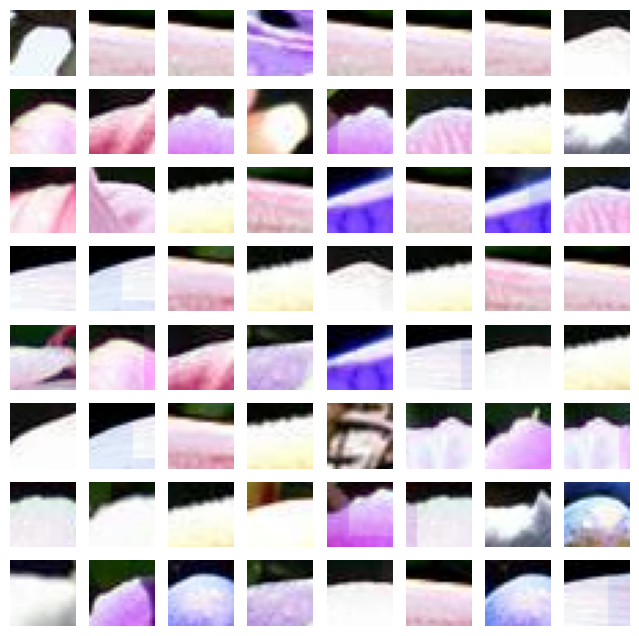

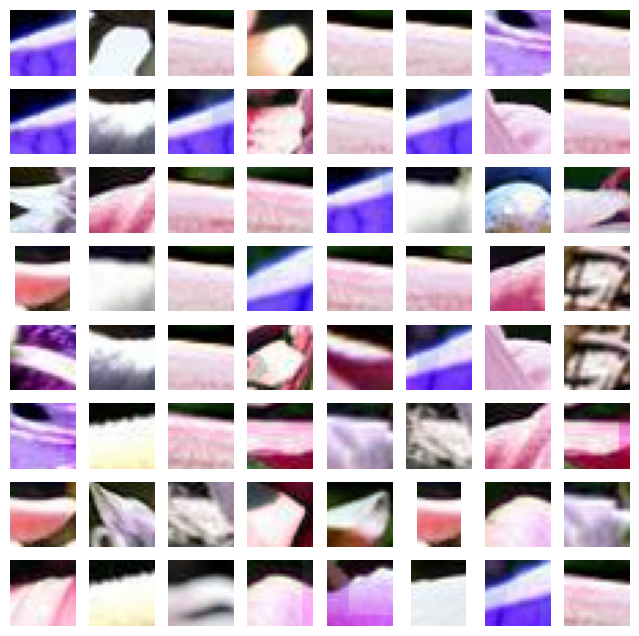

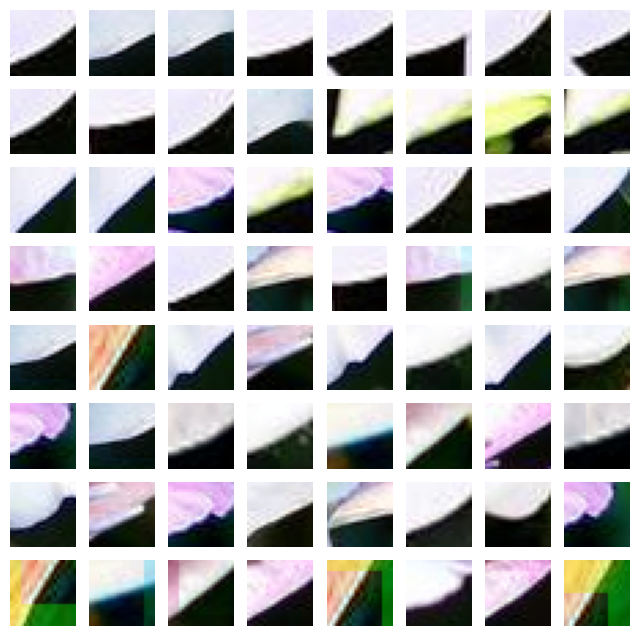

In [ ]:
find_max_act(C3, filter=0, W=12)#, img_size=img.size)
find_max_act(C3, filter=1, W=12)#, img_size=img.size)
find_max_act(C3, filter=2, W=12)#, img_size=img.size)

In [ ]:
all_data = []
C1 = []
C2 = []
C3 = []

def store_activation(L, m, grad_in, grad_out):
    L.append(grad_out.detach().cpu().numpy())


try:
    h1 = res_net.network[0].register_forward_hook(lambda *args: store_activation(C1, *args))
    h2 = res_net.network[8].net[0].register_forward_hook(lambda *args: store_activation(C2, *args))
    h3 = res_net.network[15].net[0].register_forward_hook(lambda *args: store_activation(C3, *args))

    for it, (data, label) in enumerate(validset):
        all_data.append(undo_transform(data.numpy()))
        if device is not None:
            data, label = data.to(device), label
        result = res_net(data.unsqueeze(0))
finally:
    h1.remove()
    h2.remove()
    h3.remove()

all_data = np.vstack(all_data)
C1 = np.vstack(C1)
C2 = np.vstack(C2)
C3 = np.vstack(C3)

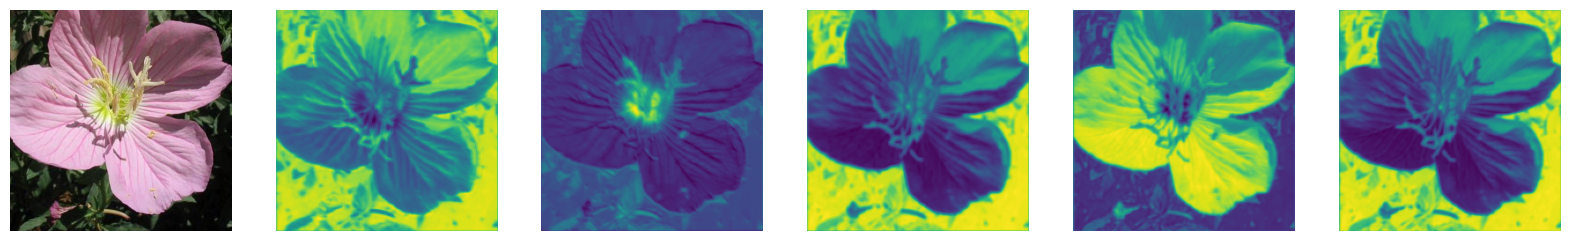

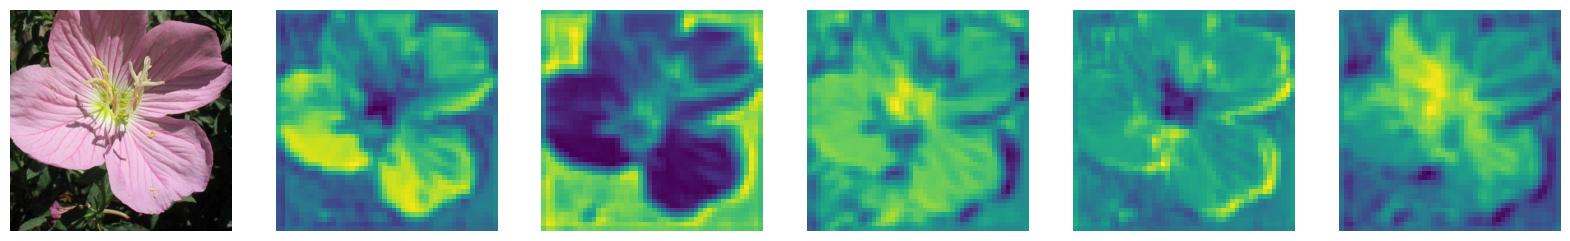

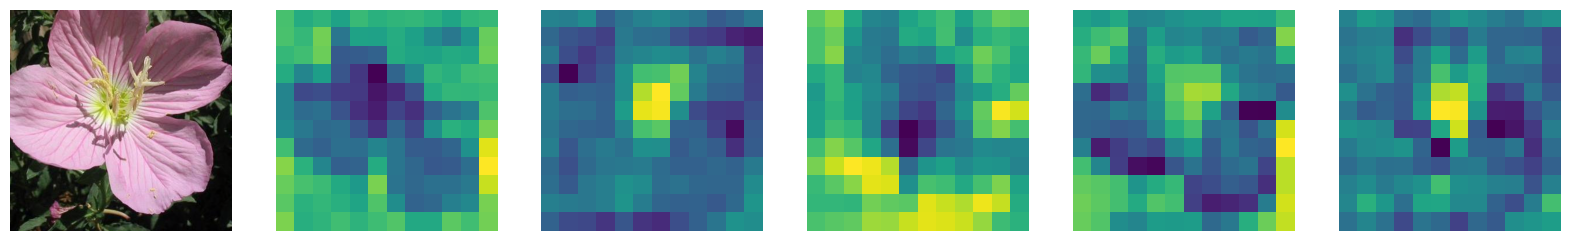

In [ ]:
for i in range(1):
    viz_act(all_data[0], C1[i, :5])


for i in range(1):
    viz_act(all_data[0], C2[i, :5])

for i in range(1):
    viz_act(all_data[0], C3[i, :5])